In [3]:
import numpy as np
import numpy.matlib
import os
import cv2
import glob
import matplotlib.pyplot as plt
import shutil
from sklearn import decomposition
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.optimizers import Adadelta, SGD
import pandas as pd
from keras.utils.np_utils import to_categorical
np.random.seed(42)

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (15, 15)      # setting default size of plots

In [4]:
# 预处理：司机-类别-图片名字
driver_char = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022',
                  'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045',
                  'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061',
                  'p064', 'p066', 'p072', 'p075', 'p081']
driver_data = pd.read_csv('driver_imgs_list.csv')
driver = driver_data['subject']
driver_class = driver_data['classname']
driver_img = driver_data['img']
driver_dict = dict()
for i in range(len(driver)):
    if driver[i] not in driver_dict.keys():
        driver_dict[driver[i]] = dict()
    if driver_class[i] not in driver_dict[driver[i]].keys():
        driver_dict[driver[i]][driver_class[i]] = []
    driver_dict[driver[i]][driver_class[i]].append(driver_img[i])


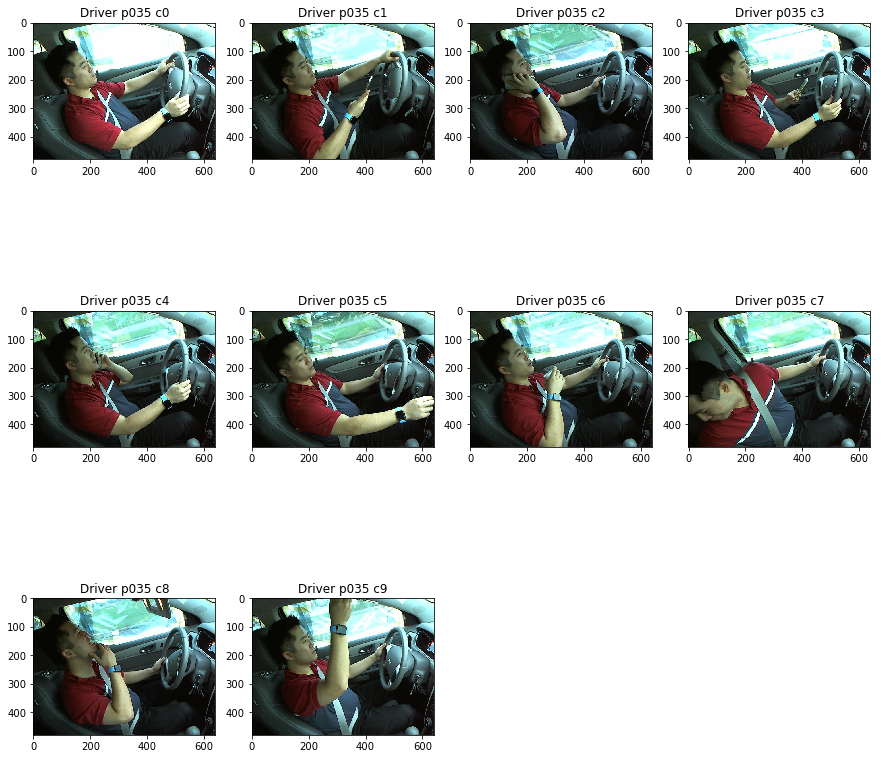

In [5]:
# 打印一位司机的所有动作
T = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
fig_1 = plt.figure()
for i, t in enumerate(T):
    name = (driver_dict['p035'][t][0])
    path = os.path.join('.', 'imgs', 'train_',name)
    img = cv2.imread(path)
    img = img[:,:,::-1]
    p035 = fig_1.add_subplot(3,4,i+1)
    p035.imshow(img)
    p035.set_title("Driver p035 c"+str(i))

plt.show()
fig_store_path = os.path.join('.', 'report-images', 'fig_1')
fig_1.savefig(fig_store_path)

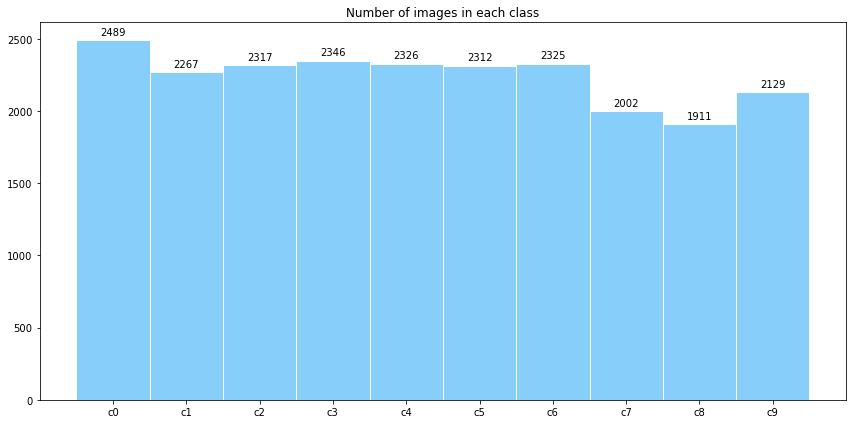

In [6]:
# 统计每个类别的图片数量
classes = np.zeros(10)
drivers = np.zeros(26)
for i in range(10):
    p = os.path.join('.', 'imgs', 'train', 'c'+str(i), '*.jpg')
    files = glob.glob(p)
    classes[i] = len(files)

for i in range(26):
    for j in range(10):
        drivers[i] += len(driver_dict[driver_char[i]]['c'+str(j)])
x_name = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
x_pin = np.arange(10)+1

fig, ax0 = plt.subplots(figsize=(12, 6))
rect1 = ax0.bar(x_pin,classes,width = 1,facecolor = 'lightskyblue',edgecolor = 'white')

ax0.set_title('Number of images in each class')
ax0.set_xticks(x_pin)
ax0.set_xticklabels(x_name)

for i, rect in enumerate(rect1):
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2., height*1.01, "%d"%classes[i],ha='center', va='bottom')

fig.tight_layout()
plt.show()
fig_store_path = os.path.join('.', 'report-images', 'fig_2')
fig.savefig(fig_store_path)

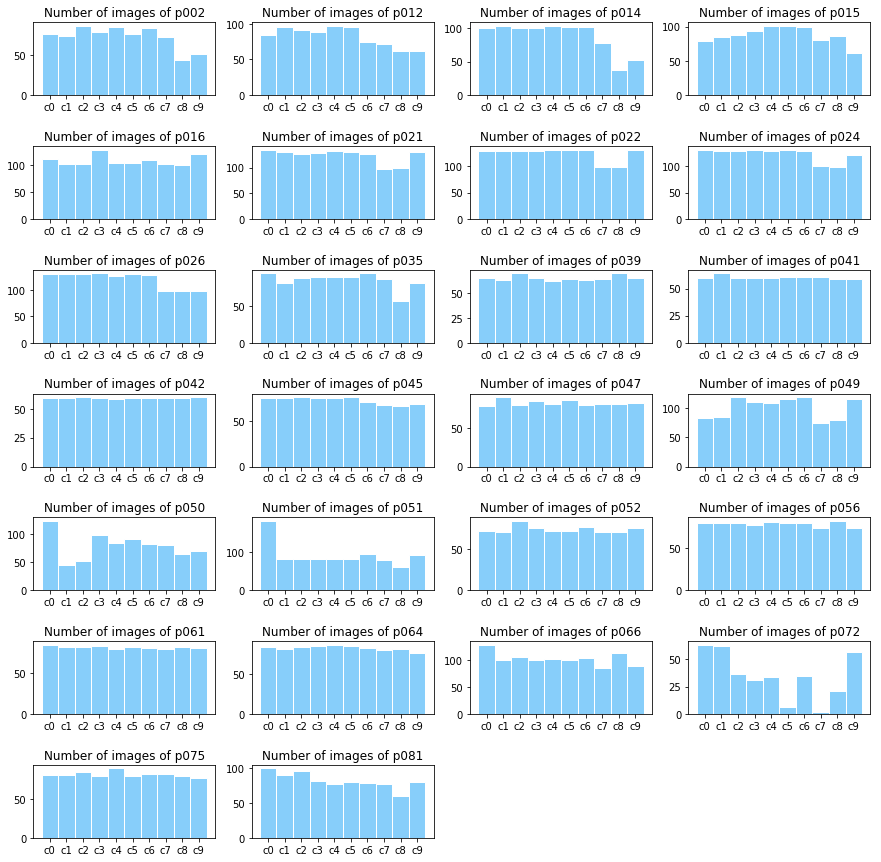

In [7]:
# 统计每位司机每个类别的图片数量
x_name = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
x_pin = np.arange(10)+1
fig = plt.figure()
fig.subplots_adjust(hspace = 0.7)
for i in range(26):
    y = np.zeros(10)
    for j in range(10):
        y[j] = len(driver_dict[driver_char[i]][x_name[j]])
    
    ax = fig.add_subplot(7, 4,i+1)
    ax.bar(x_pin,y,width = 1,facecolor = 'lightskyblue',edgecolor = 'white')

    ax.set_title('Number of images of '+driver_char[i])
    ax.set_xticks(x_pin)
    ax.set_xticklabels(x_name)
    
plt.show()
fig_store_path = os.path.join('.', 'report-images', 'fig_3')
fig.savefig(fig_store_path)

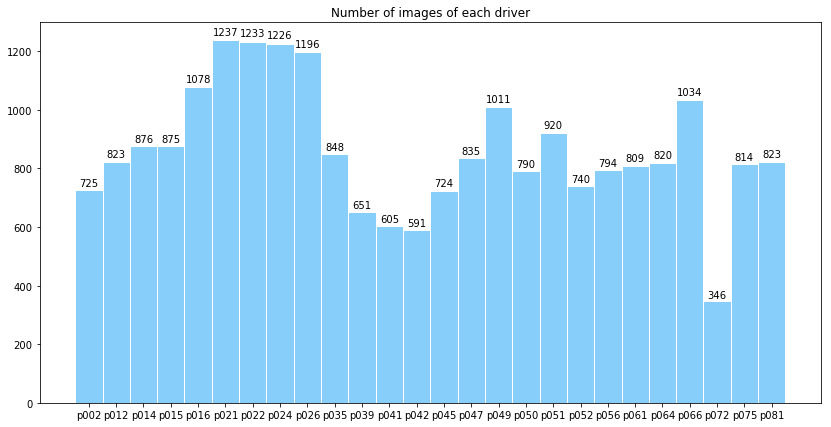

In [8]:
# 每个司机的图片数目
x_pin = np.arange(26)+1
y = np.zeros(26)
for i in range(26):
    for j in range(10):
        y[i] += len(driver_dict[driver_char[i]][x_name[j]])
    
fig, ax = plt.subplots(figsize=(14, 7))
rect1 = ax.bar(x_pin,y,width = 1,facecolor = 'lightskyblue',edgecolor = 'white')

ax.set_title('Number of images of each driver')
ax.set_xticks(x_pin)
ax.set_xticklabels(driver_char)

for i, rect in enumerate(rect1):
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2., height*1.01, "%d"%y[i],ha='center', va='bottom')
    
plt.show()
fig_store_path = os.path.join('.', 'report-images', 'fig_4')
fig.savefig(fig_store_path)

In [9]:
# 训练集和验证集的loss的accuracy数据
abandon_driver_list = ['p022_01', 'p066', 'p022', 'p021', 'p039', 'p012', 'p042', 'p002']
loss_p022_01 = [0.1643, 0.0364, 0.0154]
val_loss_p022_01 = [0.4466, 1.3184, 0.1361]
acc_p022_01 = [0.9597, 0.9924, 0.9965]
val_acc_p022_01 = [0.9023, 0.8897, 0.9696]

loss_p066 = [0.1325, 0.0226, 0.0089]
val_loss_p066 = [0.8241, 0.8329, 0.8577]
acc_p066 = [0.9644, 0.9947, 0.9980]
val_acc_p066 = [0.8241, 0.8329, 0.8577]

loss_p022 = [0.1388, 0.0216, 0.0092]
val_loss_p022 = [0.0890, 0.1852, 0.4605]
acc_p022 = [0.9652,0.9949, 0.9980]
val_acc_p022 = [0.9736, 0.9711, 0.9186]

loss_p021 = [0.1504, 0.0300, 0.0103]
val_loss_p021 = [1.3081, 0.4517, 0.4731]
acc_p021=[0.9617, 0.9928, 0.9974]
val_acc_p021 = [0.8627, 0.9196, 0.9243]

loss_p039 = [0.1395, 0.0272, 0.0095]
val_loss_p039 = [0.7815, 0.1926, 0.1781]
acc_p039 = [0.9631, 0.9939, 0.9977]
val_acc_p039 = [0.8159, 0.9290, 0.9525]

loss_p012 = [0.1610, 0.0344, 0.0115]
val_loss_p012 = [1.2080, 0.8345, 0.7672]
acc_p012 = [0.9587, 0.9923, 0.9963]
val_acc_p012 = [0.8648, 0.8694, 0.8521]

loss_p042 = [0.1606, 0.0226, 0.0124]
val_loss_p042 = [0.0396, 0.2575, 0.8963]
acc_p042 = [0.9595, 0.9943, 0.9970]
val_acc_p042 = [0.9900, 0.9232, 0.8969]

loss_p002 = [0.1577, 0.0308, 0.0074]
val_loss_p002 = [0.5442, 0.3210, 0.6362]
acc_p002 = [0.9600, 0.9931, 0.9979]
val_acc_p002 = [0.9079, 0.9218, 0.9151]

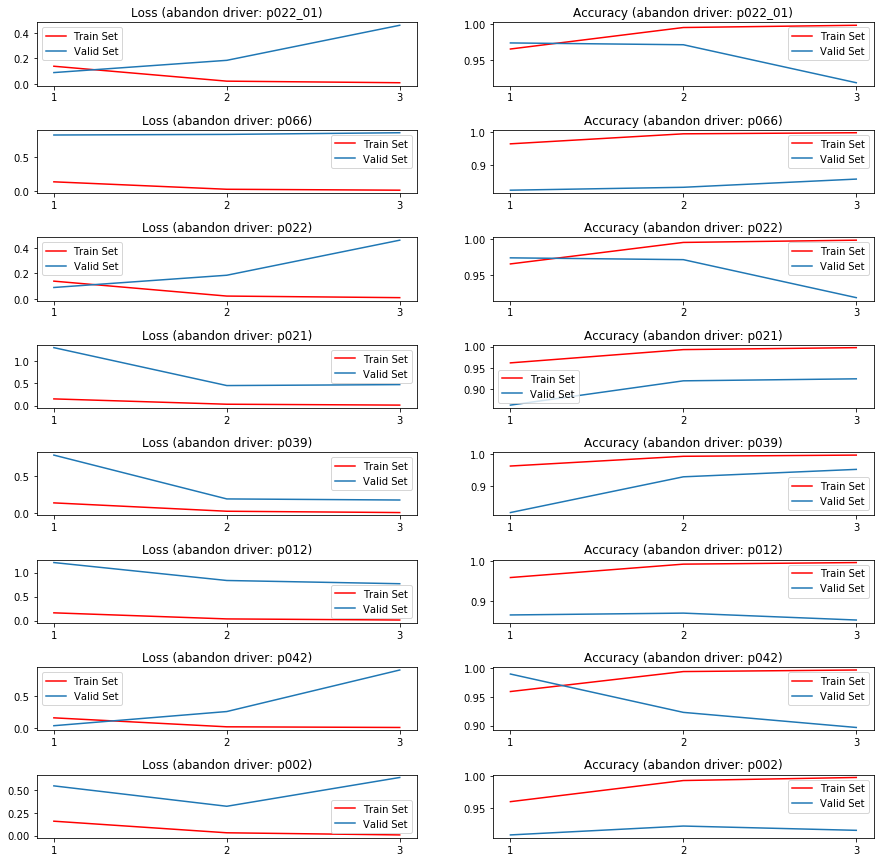

In [10]:
# 训练集和验证集loss-epoch的accuracy-epoch曲线图
x_name = ['1', '2', '3']
x_pin = np.arange(3)+1
fig = plt.figure()
fig.subplots_adjust(hspace = 0.7)

ax = fig.add_subplot(8, 2, 1)
ax.plot(x_pin,loss_p022,'r',x_pin,val_loss_p022)
ax.set_title('Loss (abandon driver: p022_01)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 2)
ax.plot(x_pin,acc_p022,'r',x_pin,val_acc_p022)
ax.set_title('Accuracy (abandon driver: p022_01)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 3)
ax.plot(x_pin,loss_p066,'r',x_pin,val_loss_p066)
ax.set_title('Loss (abandon driver: p066)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 4)
ax.plot(x_pin,acc_p066,'r',x_pin,val_acc_p066)
ax.set_title('Accuracy (abandon driver: p066)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 5)
ax.plot(x_pin,loss_p022,'r',x_pin,val_loss_p022)
ax.set_title('Loss (abandon driver: p022)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 6)
ax.plot(x_pin,acc_p022,'r',x_pin,val_acc_p022)
ax.set_title('Accuracy (abandon driver: p022)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 7)
ax.plot(x_pin,loss_p021,'r',x_pin,val_loss_p021)
ax.set_title('Loss (abandon driver: p021)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 8)
ax.plot(x_pin,acc_p021,'r',x_pin,val_acc_p021)
ax.set_title('Accuracy (abandon driver: p021)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 9)
ax.plot(x_pin,loss_p039,'r',x_pin,val_loss_p039)
ax.set_title('Loss (abandon driver: p039)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 10)
ax.plot(x_pin,acc_p039,'r',x_pin,val_acc_p039)
ax.set_title('Accuracy (abandon driver: p039)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 11)
ax.plot(x_pin,loss_p012,'r',x_pin,val_loss_p012)
ax.set_title('Loss (abandon driver: p012)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 12)
ax.plot(x_pin,acc_p012,'r',x_pin,val_acc_p012)
ax.set_title('Accuracy (abandon driver: p012)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 13)
ax.plot(x_pin,loss_p042,'r',x_pin,val_loss_p042)
ax.set_title('Loss (abandon driver: p042)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 14)
ax.plot(x_pin,acc_p042,'r',x_pin,val_acc_p042)
ax.set_title('Accuracy (abandon driver: p042)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 15)
ax.plot(x_pin,loss_p002,'r',x_pin,val_loss_p002)
ax.set_title('Loss (abandon driver: p002)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

ax = fig.add_subplot(8, 2, 16)
ax.plot(x_pin,acc_p002,'r',x_pin,val_acc_p002)
ax.set_title('Accuracy (abandon driver: p002)')
ax.set_xticks(x_pin)
ax.set_xticklabels(x_name)
plt.legend(['Train Set', 'Valid Set'])

plt.show()
fig_store_path = os.path.join('.', 'report-images', 'fig_5')
fig.savefig(fig_store_path)

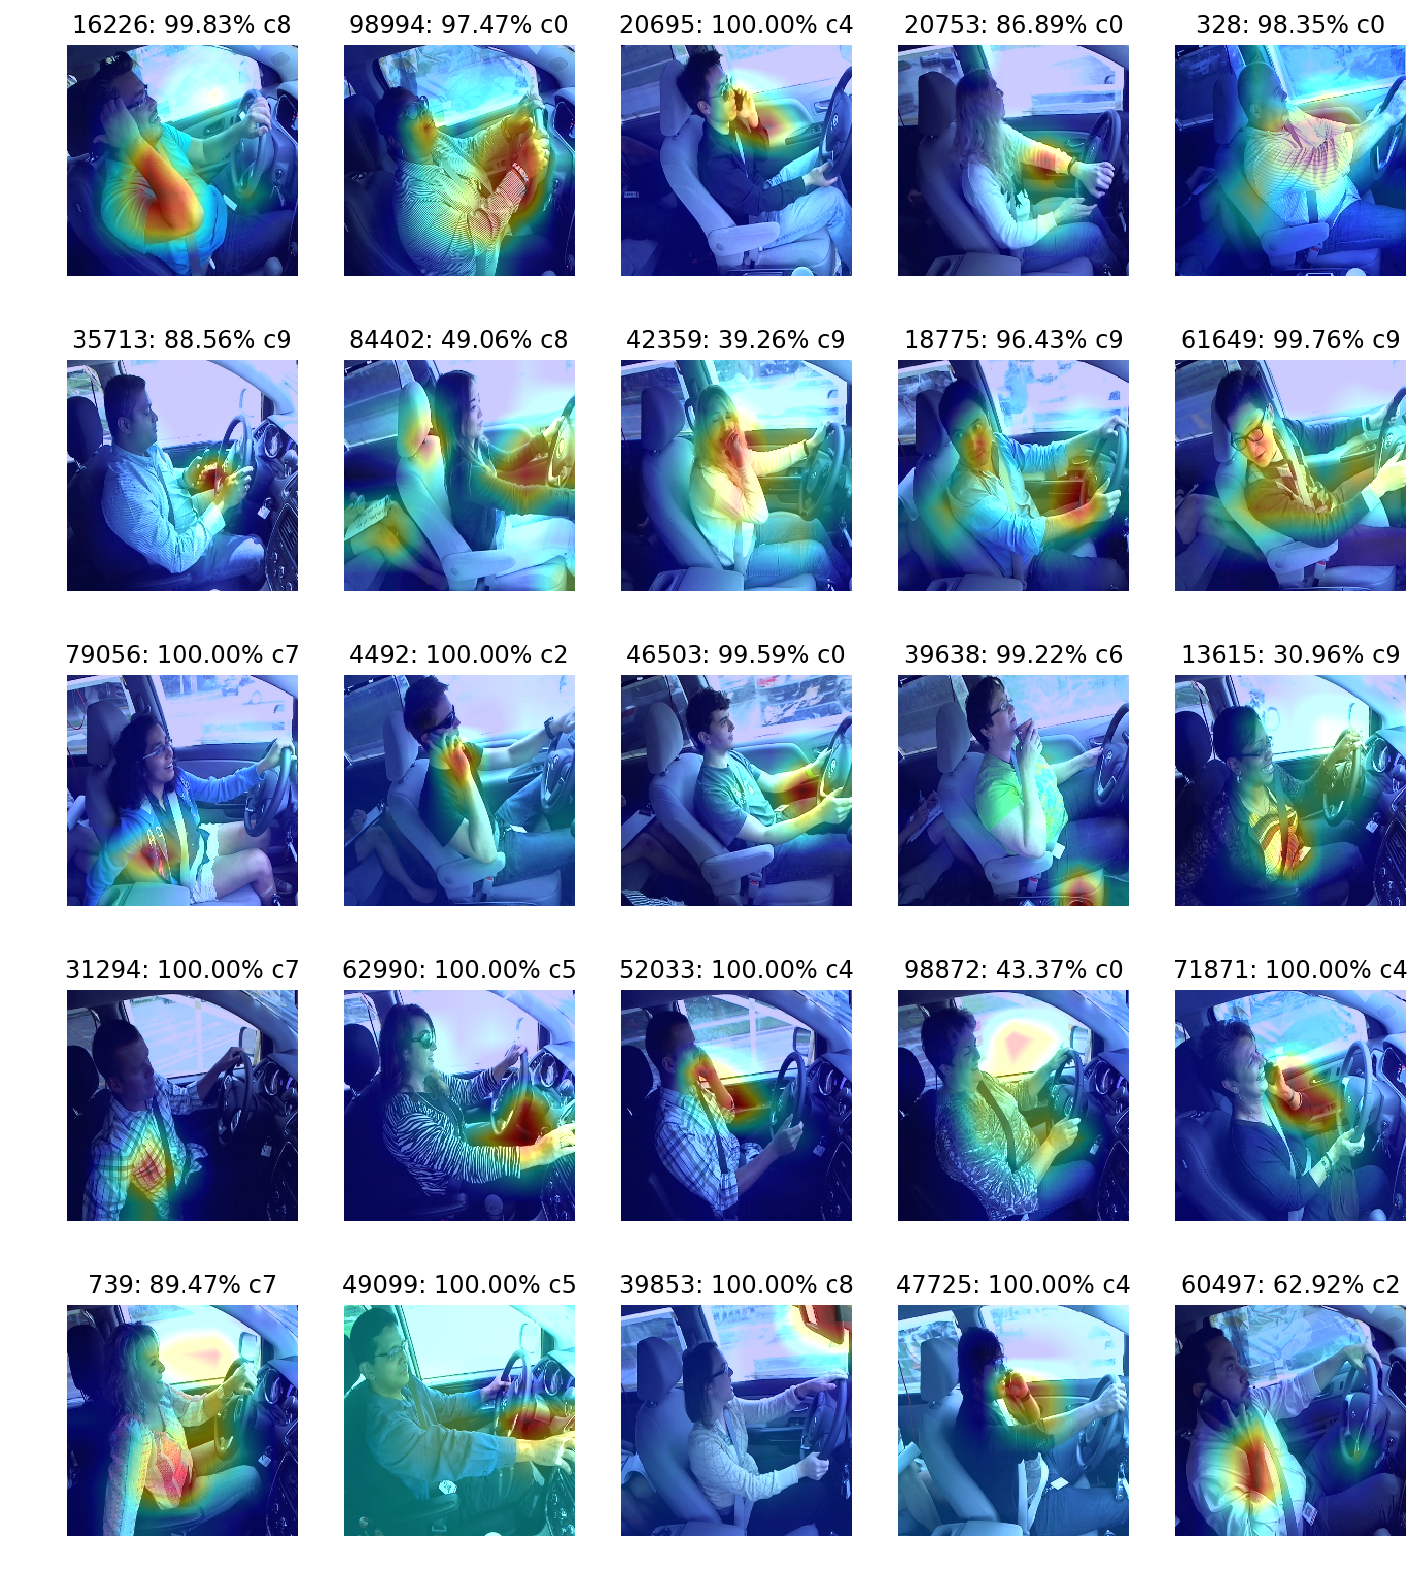

In [18]:
# CAM，一副图包含了25位司机的热感图，随机产生10张这样的图片，方便分析
%config InlineBackend.figure_format = 'retina'
model = model_from_json(open('resnet50_models/ResNet50_model_1.json').read())  
model.load_weights('resnet50_models/ResNet50_model_1.h5')
#zip([x.name for x in model.layers], range(len(model.layers)))
weights = model.layers[-1].get_weights()[0]
#print weights.shape # Get the weights of the FC layer, should be of size (10, 2048)
# model.layers[172]: The Conv output before the avg pooling layer
model_cam = Model(model.input, [model.layers[172].output, model.output])

path = os.path.join('.', 'imgs','test','*.jpg')
img_names = glob.glob(path)

fig = plt.figure(figsize=(12, 14))
for j in range(10):    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_name = img_names[np.random.randint(0, len(img_names) - 1)]
        img = cv2.imread(img_name)
        img = cv2.resize(img, (224, 224))
        x = img.copy()
        x.astype(np.float32)
        conv_outputs, prediction = model_cam.predict(np.expand_dims(x, axis=0))

        prediction = prediction[0]
        conv_outputs = conv_outputs[0]
        # conv_outputs.shape: (7,7,2048)

        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])

        for i, w in enumerate(weights):
            cam += np.sum(w) * conv_outputs[:,:,i]

        cam -= cam.min()
        cam /= cam.max()

        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0)] = 0

        out = cv2.addWeighted(img[:,:,::-1], 0.8, heatmap, 0.4, 0)


        plt.axis('off')
        plt.imshow(out)
        number = os.path.basename(img_name)
    
        number = number.split('_')[1].split('.')[0]
        plt.title(number+': %.2f%%' % (np.max(prediction*100)) + " c"+str(np.argmax(prediction)))

    fig_store_path = os.path.join('.', 'report-images', 'fig_'+str(8+j))
    fig.savefig(fig_store_path)